In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pandas as pd
import glob
import re

# Filepath directories and read (complete) stationlist

In [2]:
fp_stationlist= r"/all_mounts/masp26/SMOS_artic/BennetProjects/Paper3/StationLists/Stationlist_Mackenzie2019_forSnap.csv"
StationList = pd.read_csv(fp_stationlist)
StationList['Name'] = StationList['Name'].map(lambda x: re.sub('_b', '', x)) # remove "_b" from Stationnames
StationList['Name'] = StationList['Name'].map(lambda x: x.lstrip('STN')) # remove "STN" from Stationnames
StationList['Name'] = StationList['Name'].map(lambda x: re.sub('alt', '', x)) # remove "alt" from Stationnames
#StationList['Name'] = StationList['Name'].map(lambda x: x.rstrip('alt')) # remove "_b" from Stationnames
new = StationList["Datetime"].str.split("T", 1, expand = True)
StationList['date']= StationList["date"]= new[0]
StationList['date'] = pd.to_datetime(StationList['date'])

fd_CDOM_data = "/all_mounts/masp26/SMOS_artic/BennetProjects/Paper3/_data/CDOM/v20191016/data/"

# collect list of datetimes from filenames in directory

In [4]:
# collect datetimes from filenames
files = pd.Series(os.listdir(fd_CDOM_data))
Dates=[]
for date in pd.date_range('2019-01-01', '2020-01-01', freq='d'):
    for file_name in files[files.str.contains(date.strftime('%Y%m%d'))]:
        Dates.append(date)
        
Datetimes=[]
for e in Dates:
    DTobject= e.to_pydatetime()
    Datetimes.append(DTobject)
#-------------------------------------------------------------------

# Read all cdom files and put into panda dataframe

In [5]:
all_files =sorted(glob.glob(fd_CDOM_data + "/*.dat"))

li = []

for i, filename in enumerate(all_files):
    df = pd.read_csv(filename, delimiter=" ") # read .dat file
    result = df.transpose() # switch X and Y axis
    result.columns = result.iloc[0] # define 0nd row as header (index)
    result.insert(loc=0, column='filename', value=os.path.basename(filename)) # add filename as column in position = 0   
    result.insert(loc=1, column='date', value=Datetimes[i]) # add datetime as column in position = 0
    result.insert(loc=2, column='depth', value=os.path.basename(filename[-22:-19])) # add depth as column in position = 0
    result.insert(loc=2, column='pathlength', value=os.path.basename(filename[-14:-11])) # add pathlenght as column in position = 0
    result.insert(loc=2, column='Name', value=os.path.basename(filename.split("_stn",1)[1].split("_dep",1)[0] )) # add pathlenght as column in position = 0
    
    li.append(result) # add file to overall collector

frame = pd.concat(li, axis=0, ignore_index=True) # concatate on axis 0
CDOM_data_list=frame.iloc[1::3] # remove every 1 and 3 row (wavelengths and qf)

# Merge Stationlist with CDOM data

In [49]:
CDOMwithMetadata = pd.merge(CDOM_data_list, StationList,  how='left', left_on=['Name','date'], right_on = ['Name','date'])


In [50]:
#for index, row in CDOMwithMetadata.iterrows():
#    print row["Latitude"], row["Name"], row["date"]

# Write data to csv

In [51]:
CDOMwithMetadata.to_csv("/all_mounts/masp26/SMOS_artic/BennetProjects/Paper3/_data/CDOM/CDOMwithMetadata_v1.csv", sep='\t', encoding='utf-8')

# Plot all CDOM finals

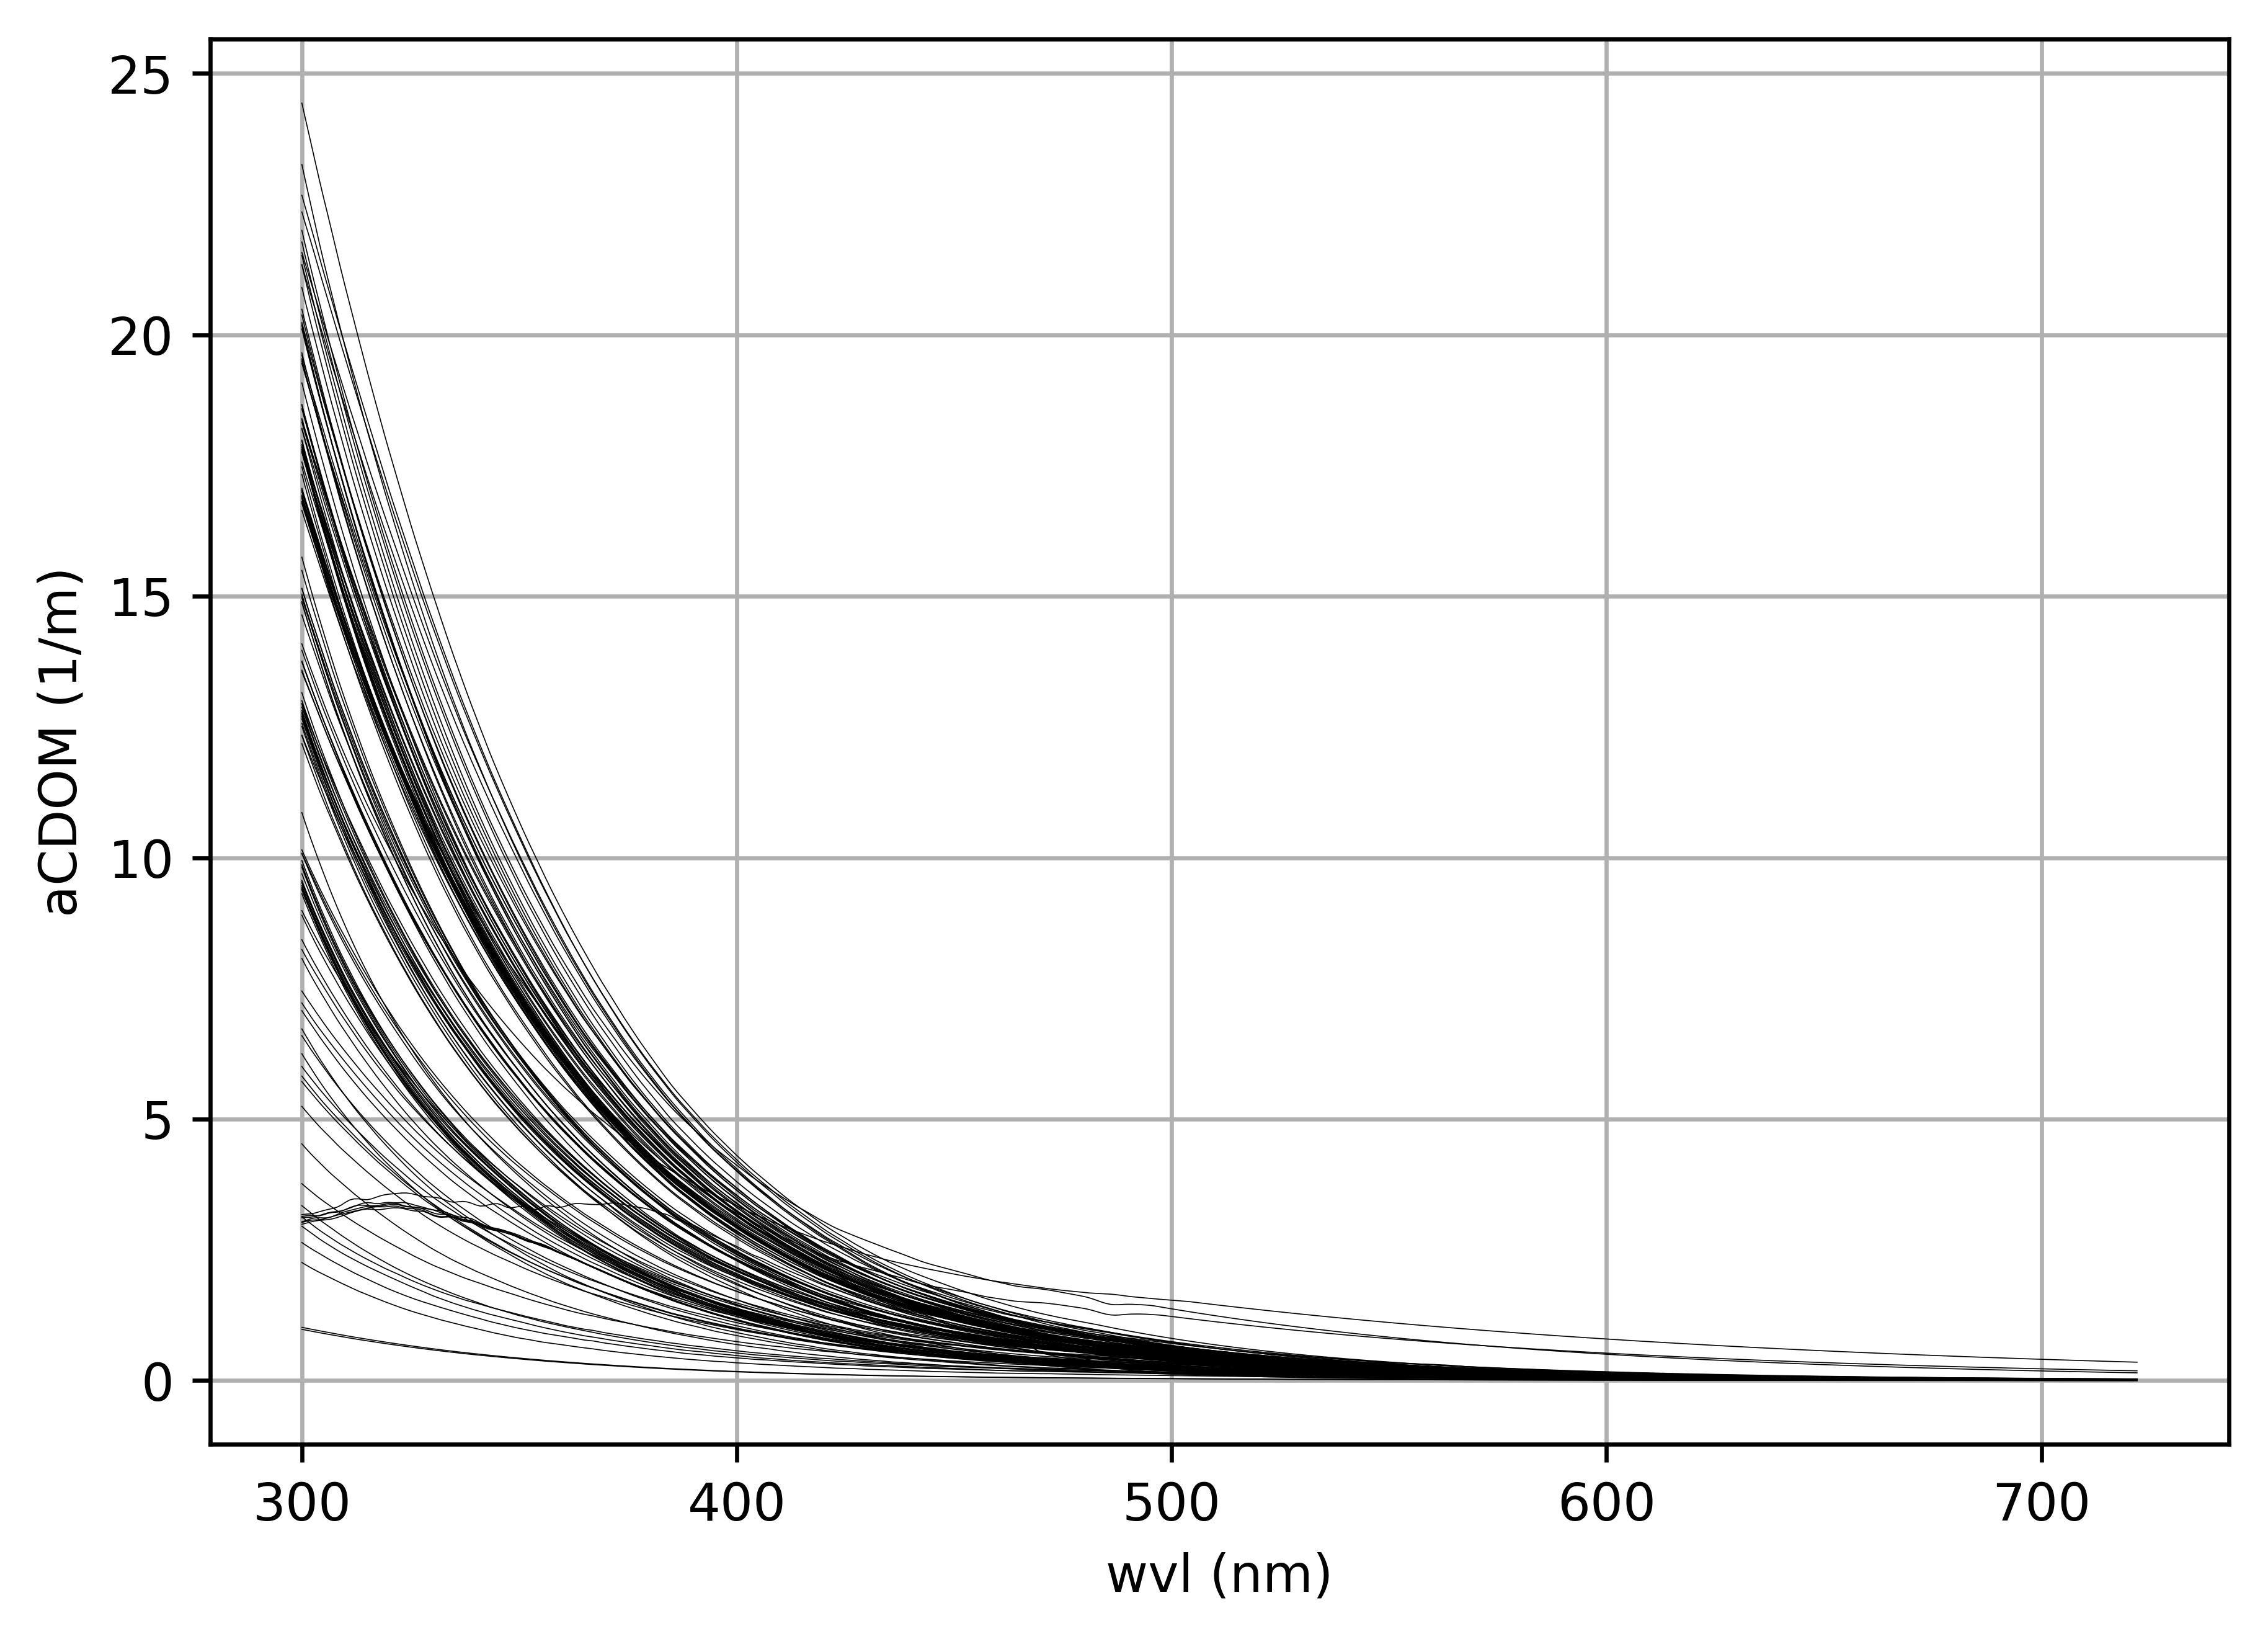

In [52]:
Wvl_range=np.arange(300,723, 1)
plt.figure(figsize=(7,5), dpi=600)


for index, row in CDOM_data_list.iterrows():
    aCDOM = row[105:].tolist()
    #print aCDOM[:]
    #print "\n"
    plt.plot( Wvl_range, aCDOM, "k-", lw=0.2)
    
plt.grid()
plt.xlabel("wvl (nm)")
plt.ylabel("aCDOM (1/m)")
plt.savefig("/all_mounts/masp26/SMOS_artic/BennetProjects/Paper3/_data/CDOM/v20191016/figures/all_files300to722.png")
plt.show()
